In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import matplotlib.cm as cm
from scipy.misc import imresize
import cv2
import pandas as pd
import scipy.io as io

In [2]:
def data_extraction(path):
    data_l, data_r, data_all = [], [], []
    nor_data = io.loadmat(path)
    temp = nor_data['data']
    r = temp['right']
    l = temp['left']
    r_temp = r[0,0]
    l_temp = l[0,0]
    data_r.append(r_temp['image'][0][0])
    data_r.append(r_temp['gaze'][0][0])
    data_r.append(r_temp['pose'][0][0])
    data_l.append(l_temp['image'][0][0])
    data_l.append(l_temp['gaze'][0][0])
    data_l.append(l_temp['pose'][0][0])
    for i in range(3):
        data_all.append(data_r[i])   #0 -> r_img, 1-> l_img, 2-> r_gaze, 3->l_gaze..
        data_all.append(data_l[i])
    return data_all

In [3]:
def label_extraction(path, screen_path):
    txt = pd.read_csv(path, sep = ' ', header= None)
    screen = io.loadmat(screen_path)
    df_anno = pd.DataFrame(txt)
    data_frame = pd.DataFrame()
    data_frame['Screen_x'] = df_anno[:][24] / screen['width_pixel'][0][0]
    data_frame['Screen_y'] = df_anno[:][25] / screen['height_pixel'][0][0]
    return data_frame

In [4]:
data_test = data_extraction('../Data/MPIIGaze/Data/Normalized/p00/day01.mat')
label_text = label_extraction('../Data/MPIIGaze/Data/Original/p00/day01/annotation.txt',
                             '../Data/MPIIGaze/Data/Original/p00/Calibration/screenSize.mat')

In [5]:
data_test[1][0].shape

(36, 60)

In [6]:
def make_dataset_img_label(image_shape, label_shape, data_list, label_list):
    length = len(data_list[0])
    left_img = np.zeros([length,image_shape])
    right_img = np.zeros([length,image_shape])
    label = np.zeros([length,label_shape])
    for n in range(length):
        left_img[n, :] = data_list[1][n].reshape(image_shape)
        right_img[n, :] = data_list[0][n].reshape(image_shape)
        label[n, :] = [label_list['Screen_x'][n], label_list['Screen_y'][n]]
        
    return right_img, left_img, label

def make_dataset_gaze_pose(data_shape, data_list):
    length = len(data_list[0])
    left_pose = np.zeros([length,data_shape])
    right_pose = np.zeros([length,data_shape])
    left_gaze = np.zeros([length,data_shape])
    right_gaze = np.zeros([length,data_shape])
    for n in range(length):
        left_gaze[n, :] = data_list[3][n]
        right_gaze[n, :] = data_list[2][n]
        left_pose[n, :] = data_list[5][n]
        right_pose[n, :] = data_list[4][n]
    return left_gaze, right_gaze, left_pose, right_pose

In [7]:
RE_img_data, LE_img_data, dataset_label = make_dataset_img_label(36 * 60, 2, data_test, label_text)
LE_gaze_data, RE_gaze_data, LE_pose_data, RE_pose_data = make_dataset_gaze_pose(3, data_test)

# Make graph for eye images

In [8]:
def model_for_image(X_img, keep_prob, name):
    with tf.name_scope("Image_layer_1_" + name) as scope:
        W1 = tf.Variable(tf.random_normal([4, 4, 1, 5], stddev=0.01))
        L1 = tf.nn.conv2d(X_img, W1, strides=[1, 2, 2, 1], padding='SAME')
        L1 = tf.nn.relu(L1)
        """
        tf.summary.histogram("img" + name, X_img)
        tf.summary.histogram("W1_img"+ name, W1)
        tf.summary.histogram("layer_1" + name, L1)
        """
    with tf.name_scope("Image_layer_2_" + name) as scope:
        W2 = tf.Variable(tf.random_normal([2, 2, 5, 10], stddev=0.01))
        L2 = tf.nn.conv2d(L1, W2, strides=[1, 2, 2, 1], padding='SAME')
        L2 = tf.nn.relu(L2)
        L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
        L2_flat = tf.reshape(L2, [-1, 5 * 8 * 10])
        """
        tf.summary.histogram("W2_img "+ name, W2)
        tf.summary.histogram("layer_2 " + name, L2)
        """

    with tf.name_scope("Image_layer_3_" + name) as scope:
        W3 = tf.get_variable("W3_"+name ,shape= [400, 256],
                             initializer= tf.contrib.layers.xavier_initializer())
        b3 = tf.Variable(tf.random_normal([256]))
        L3 = tf.nn.relu(tf.matmul(L2_flat, W3) + b3)
        L3 = tf.nn.dropout(L3, keep_prob= keep_prob)
        """
        tf.summary.histogram("W3_img"+ name, W3)
        tf.summary.histogram("b3_img"+ name, b3)
        tf.summary.histogram("layer_3" + name, L3)
       """     
    with tf.name_scope("Image_layer_4_" + name) as scope:
        W4 = tf.get_variable("W4_"+name ,shape= [256, 128],
                             initializer= tf.contrib.layers.xavier_initializer())
        b4 = tf.Variable(tf.random_normal([128]))
        L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
        L4 = tf.nn.dropout(L4, keep_prob= keep_prob)
        """
        tf.summary.histogram("W4_img"+ name, W4)
        tf.summary.histogram("b4_img"+ name, b4)
        tf.summary.histogram("layer_4" + name, L4)
       """ 
    with tf.name_scope("Image_layer_5_" + name) as scope:
        W5 = tf.get_variable("W5_"+name ,shape= [128, 64],
                             initializer= tf.contrib.layers.xavier_initializer())
        b5 = tf.Variable(tf.random_normal([64]))
        logits = tf.matmul(L4, W5) + b5
        """
        tf.summary.histogram("W5_img"+ name, W5)
        tf.summary.histogram("b5_img"+ name, b5)
        tf.summary.histogram("logits" + name, logits)
        """
    return logits

# Make graph for other datas

In [9]:
def model_for_others(X, name):
    with tf.name_scope("Layer_1_" + name) as scope:
        W1 = tf.get_variable("W1_"+name ,shape= [3, 3],
                             initializer= tf.contrib.layers.xavier_initializer())
        b1 = tf.Variable(tf.random_normal([3]))
        L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

    with tf.name_scope("Layer_2_" + name) as scope:
        W2 = tf.get_variable("W2_"+name ,shape= [3, 3],
                             initializer= tf.contrib.layers.xavier_initializer())
        b2 = tf.Variable(tf.random_normal([3]))
        logits = tf.matmul(L1, W2) + b2
    
    return logits

# Define variable and make graphs using function

In [10]:
learning_rate = 0.001

Y = tf.placeholder(tf.float32, [None, 2])
keep_prob = tf.placeholder(tf.float32)

X_left = tf.placeholder(tf.float32, [None, 2160])
X_right = tf.placeholder(tf.float32, [None, 2160])
X_img_left = tf.reshape(X_left, [-1, 36, 60, 1])   
X_img_right = tf.reshape(X_right, [-1, 36, 60, 1]) 

X_gaze_r = tf.placeholder(tf.float32, [None, 3])
X_gaze_l = tf.placeholder(tf.float32, [None, 3])
X_pose_r = tf.placeholder(tf.float32, [None, 3])
X_pose_l = tf.placeholder(tf.float32, [None, 3])

LE_img = model_for_image(X_img_left, keep_prob, 'left_eye')  #left eye imgae
RE_img = model_for_image(X_img_right, keep_prob, 'right_eye')#right eye image
LE_pose = model_for_others(X_pose_l, 'left_pose')
LE_gaze = model_for_others(X_gaze_l, 'left_gaze')
RE_pose = model_for_others(X_pose_r, 'right_pose')
RE_gaze = model_for_others(X_gaze_r, 'right_gaze')

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Integrate the gaze graph

In [11]:
with tf.name_scope("Layer_gaze_merged") as scope:
    LE_gaze_W = tf.get_variable("LE_gaze_W" ,shape= [3, 3],
                             initializer= tf.contrib.layers.xavier_initializer())

    RE_gaze_W = tf.get_variable("RE_gaze_W" ,shape= [3, 3],
                             initializer= tf.contrib.layers.xavier_initializer())

    layer_gaze = tf.nn.relu(tf.matmul(LE_gaze, LE_gaze_W) + tf.matmul(RE_gaze, RE_gaze_W))

# Integrate the pose layer

In [12]:
with tf.name_scope("Layer_pose_merged") as scope:
    LE_pose_W = tf.get_variable("LE_pose_W" ,shape= [3, 3],
                             initializer= tf.contrib.layers.xavier_initializer())

    RE_pose_W = tf.get_variable("RE_pose_W" ,shape= [3, 3],
                             initializer= tf.contrib.layers.xavier_initializer())

    layer_pose = tf.nn.relu(tf.matmul(LE_pose, LE_pose_W) + tf.matmul(RE_pose, RE_pose_W))

# Integrate the Image layer

In [13]:
with tf.name_scope("Layer_Image_merged_1") as scope:
    LE_W_img = tf.get_variable("LE_W_img" ,shape= [64, 32],
                             initializer= tf.contrib.layers.xavier_initializer())
    RE_W_img = tf.get_variable("RE_W_img" ,shape= [64, 32],
                             initializer= tf.contrib.layers.xavier_initializer())
    layer_img = tf.nn.relu(tf.matmul(LE_img, LE_W_img) + tf.matmul(RE_img, RE_W_img))

with tf.name_scope("Layer_Image_merged_2") as scope:
    img_W = tf.get_variable("img_W" ,shape= [32, 16],
                             initializer= tf.contrib.layers.xavier_initializer())
    img_b = tf.Variable(tf.random_normal([16]))
    layer2_img = tf.nn.relu(tf.matmul(layer_img, img_W) + img_b)

with tf.name_scope("Layer_Image_merged_3") as scope:
    img_W2 = tf.get_variable("img_W2" ,shape= [16, 8],
                             initializer= tf.contrib.layers.xavier_initializer())
    img_b2 = tf.Variable(tf.random_normal([8]))
    layer3_img= tf.nn.relu(tf.matmul(layer2_img, img_W2) + img_b2)

with tf.name_scope("Layer_Image_merged_Last") as scope:
    Final_W_img = tf.get_variable("Final_W_img" ,shape= [8, 3],
                             initializer= tf.contrib.layers.xavier_initializer())
    Final_b_img = tf.Variable(tf.random_normal([3]))
    Final_layer_img= tf.nn.relu(tf.matmul(layer3_img, Final_W_img) + Final_b_img)

In [14]:
with tf.name_scope("Layer") as scope:
    # Weight and bias for img layer
    All_W_img = tf.get_variable("All_W_img" ,shape= [3, 2],
                             initializer= tf.contrib.layers.xavier_initializer())
    # Weight and bias for pose layer
    All_W_pose = tf.get_variable("All_W_pose" ,shape= [3, 2],
                             initializer= tf.contrib.layers.xavier_initializer())
    # Weight and bias for gaze layer
    All_W_gaze = tf.get_variable("All_W_gaze" ,shape= [3, 2],
                             initializer= tf.contrib.layers.xavier_initializer())
    logits = (tf.matmul(Final_layer_img, All_W_img) 
              + tf.matmul(layer_pose, All_W_pose)
              + tf.matmul(layer_gaze, All_W_gaze))

cost = tf.reduce_mean(tf.square(logits-Y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

tf_variables = []  # List for saving Variables
for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)

merge = tf.summary.merge_all()
saver = tf.train.Saver()

In [19]:
cost_graph = []
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    
    global_step = 0
    
    writer = tf.summary.FileWriter('../temp/graph/graph_summary')
    writer.add_graph(sess.graph)

    print('Learning started. It takes sometime.')
    for i in range(len(RE_img_data)):
        feed_dict = {X_right: RE_img_data,X_left: LE_img_data,
                     X_gaze_r:RE_gaze_data, X_gaze_l:LE_gaze_data,
                     X_pose_r:RE_pose_data, X_pose_l:LE_pose_data,
                     Y:dataset_label, keep_prob: 0.7}
        s, _ = sess.run([merge, optimizer], feed_dict=feed_dict)   #For Tensorboard
        writer.add_summary(s, global_step=global_step)
        global_step += 1
        c = sess.run(cost, feed_dict=feed_dict)                    #For Train Variables
        cost_graph.append(c)
        if i % 100 == 0:
            print('step: {0} cost:{1}'.format(i, c))
            save_path = saver.save(sess,'../temp/variables/tensor_variables.ckpt') 

    print('Learning Finished!')

Learning started. It takes sometime.


FailedPreconditionError: Attempting to use uninitialized value All_W_gaze
	 [[node All_W_gaze/read (defined at <ipython-input-14-ebcfeff47488>:10) ]]

Caused by op 'All_W_gaze/read', defined at:
  File "/home/spow12/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/spow12/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/spow12/anaconda3/lib/python3.7/asyncio/base_events.py", line 528, in run_forever
    self._run_once()
  File "/home/spow12/anaconda3/lib/python3.7/asyncio/base_events.py", line 1764, in _run_once
    handle._run()
  File "/home/spow12/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-ebcfeff47488>", line 10, in <module>
    initializer= tf.contrib.layers.xavier_initializer())
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1479, in get_variable
    aggregation=aggregation)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1220, in get_variable
    aggregation=aggregation)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 547, in get_variable
    aggregation=aggregation)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 499, in _true_getter
    aggregation=aggregation)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 911, in _get_single_variable
    aggregation=aggregation)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1395, in __init__
    constraint=constraint)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1557, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3890, in identity
    "Identity", input=input, name=name)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/spow12/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value All_W_gaze
	 [[node All_W_gaze/read (defined at <ipython-input-14-ebcfeff47488>:10) ]]


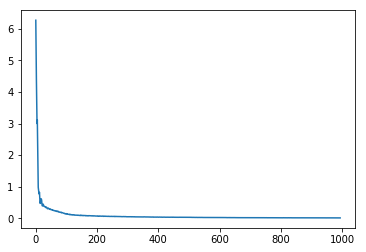

In [16]:
plt.plot(cost_graph)

In [21]:
with tf.Session() as sess:
    saver.restore(sess,'../temp/variables/tensor_variables.ckpt') 
    print("v1 : %s" % All_W_gaze.eval())

INFO:tensorflow:Restoring parameters from ../temp/variables/tensor_variables.ckpt
v1 : [[ 0.31149554 -0.29664564]
 [-0.08065403 -0.8787236 ]
 [ 0.62560695  0.29761025]]
